<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>May 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@etu.u-paris.fr</span>
</p>
</CENTER>

## <span id="section-0" style="color:#00B8DE"> 0 - Imports, Parameters, Functions </span>

In [171]:
import  as99
import  phitter
import  utils
import  numpy                                       as      np
import  matplotlib.pyplot                           as      plt
from    math                                        import  exp
from    scipy.stats                                 import  norm, johnsonsu, johnsonsb, lognorm, kstest
from    statsmodels.stats.diagnostic                import  normal_ad

np.random.seed(0)
plt.style.use('ggplot')

In [172]:
color_jlsmc     = 'blue'
color_glsmc     = 'red'
color_invalid   = 'purple'

In [173]:
# 1/24 = 1 week. 1Y = 6M | 1M = 4W --> 1Y = 24W
# 1/240 = 1/2 bday. 1W = 5 bdays
k, sigma, T, delta, dt  = 0.015, 0.01, 1, 1/24, 1/240
C1, C2, C3              = 0.05, -0.03, -0.18
r0                      = utils.obs_yield_curve(0, C1, C2, C3)
rf_ref                  = utils.obs_yield_curve(0, C1, C2, C3)
notional                = 10000

time_grid   = np.arange(0, T, dt)
N           = len(time_grid)-1
M           = 200000
dfixing     = 0.25
fixing_grid = np.arange(T+dfixing, T+5+dfixing, dfixing)
N           = len(time_grid)-1
tref        = 0.8 # 1/12 : 1 month
ind_tref, ind_delta, ind_tdelta = int(tref/dt), int(delta/dt), int((tref+delta)/dt)
alpha       = 0.99
R           = 0.04

jtypes_map      = {'SL': 1, 'SU': 2, 'SB': 3, 'SN': 4, 'ST': 5}
rev_jtypes_map  = {v: k for k, v in jtypes_map.items()}

## <span id="section-1" style="color:#00B8DE"> I - Risk Factors & Portfolio Paths </span>

In [174]:
gen_riskfactors             = lambda r0, M, time_grid: utils.gen_riskfactors(r0, k, sigma, C1, C2, C3, dt, M, time_grid)
gen_mtm                     = lambda rf_paths, time_grid: utils.gen_mtm(rf_paths, k, sigma, R, C1, C2, C3, dt, T, time_grid, fixing_grid, notional)
get_mtmdiff_nmc             = lambda M_in, rf, mtm, ind_tref: utils.get_mtmdiff_nmc(M_in, rf, mtm, k, sigma, R, C1, C2, C3, dt, T, ind_tref, ind_delta, time_grid, fixing_grid, notional)
get_var_swaption            = lambda rf, mtm, ind_tref: utils.get_var_swaption(rf, mtm, k, sigma, R, C1, C2, C3, dt, T, delta, alpha, ind_tref, time_grid, fixing_grid, notional)
percentile_matching_johnson = lambda mtm, rf_train, mtm_train, ind_tref, Nnmc, z: utils.percentile_matching_johnson(mtm, rf_train, mtm_train, k, sigma, R, C1, C2, C3, dt, T, ind_tref, ind_delta, time_grid, fixing_grid, notional, Nnmc, z)

In [175]:
S_paths         = gen_riskfactors(r0, M, time_grid)
mtm_paths       = gen_mtm(S_paths, time_grid)
mtmdiff_paths   = utils.get_mtmdiff(mtm_paths, ind_delta)
S_train         = S_paths[:, ind_tref]
mtm_train       = mtm_paths[:, ind_tref]
mtm_func        = np.linspace(np.min(mtm_train), np.max(mtm_train), 1000)
mtm_ref         = gen_mtm(np.array([[rf_ref]]), time_grid[ind_tref:ind_tref+1])[0]

Nq          = 100
Nqtail      = int(0.1*Nq)//2 # int(0.4*Nq)//2
q_main      = np.arange(1, Nq) / Nq
q_ltail     = np.linspace(0, 0.01, Nqtail+2)[1:-1]
q_utail     = np.linspace(0.99, 1, Nqtail+2)[1:-1]
q_all       = np.sort(np.unique(np.concatenate([q_ltail, q_main, q_utail])))
#q_all       = np.concat([[0], q_all, [1]])
#q_all       = np.unique(q_all)
mtm_supp    = np.quantile(mtm_train, q_all, method='inverted_cdf')
# mtm_supp = np.linspace(np.min(mtm_train), np.max(mtm_train), 110)

Mtest                           = 100
Mtest_in                        = 1000000
S_test                          = np.linspace(np.min(S_train), np.max(S_train), Mtest)
mtm_test                        = gen_mtm(S_test.reshape(-1, 1), time_grid[ind_tref:ind_tref+1]).reshape(-1)
mtmdiff_nmc_test                = get_mtmdiff_nmc(Mtest_in, S_test, mtm_test, ind_tref)
muraw_test                      = np.column_stack([np.mean(mtmdiff_nmc_test**i, axis=1) for i in range(1, 5)])
mu_test                         = utils.get_centred_moms(muraw_test)[0]
skew_test, kurt_test, _, _, _   = utils.get_skewkurt(mu_test)

Mref_in                         = 1 # 100000
mtmdiff_nmc_ref                 = get_mtmdiff_nmc(Mref_in, np.array([rf_ref]), mtm_ref, ind_tref)
muraw_ref                       = np.column_stack([np.mean(mtmdiff_nmc_ref**i, axis=1) for i in range(1, 5)])
mu_ref                          = utils.get_centred_moms(muraw_ref)[0]
skew_ref, kurt_ref, _, _, _     = utils.get_skewkurt(mu_ref)
quant_ref                       = np.quantile(mtmdiff_nmc_ref[0, :], alpha, method='inverted_cdf')

Mcomp                           = 1 # 1000
Mcomp_in                        = 1 # 100000
bin_size                        = M//Mcomp
sorted_inds                     = np.argsort(mtm_train)
selec_inds                      = np.array([sorted_inds[i*bin_size + bin_size//2] for i in range(Mcomp)])
S_comp                          = S_paths[selec_inds, ind_tref]
mtm_comp                        = gen_mtm(S_comp.reshape(-1, 1), time_grid[ind_tref:ind_tref+1])
mtmdiff_nmc_comp                = get_mtmdiff_nmc(Mcomp_in, S_comp, mtm_comp, ind_tref)
muraw_comp                      = np.column_stack([np.mean(mtmdiff_nmc_comp**i, axis=1) for i in range(1, 5)])
mu_comp                         = utils.get_centred_moms(muraw_comp)[0]
skew_comp, kurt_comp, _, _, _   = utils.get_skewkurt(mu_comp)
quant_comp                      = np.quantile(mtmdiff_nmc_comp, alpha, method='inverted_cdf', axis=1)

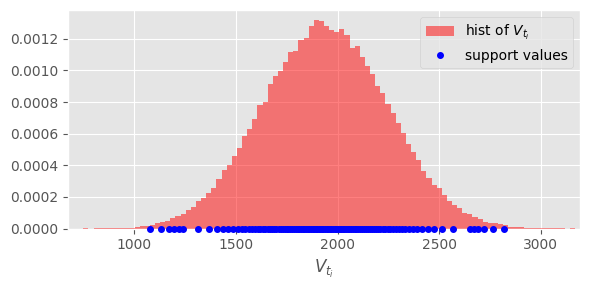

In [176]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(mtm_train, bins=100, density=True, alpha=0.5, color='red', label='hist of $V_{t_i}$')
ax.plot(mtm_supp, np.zeros_like(mtm_supp), 'o', color=color_jlsmc, label='support values', clip_on=False, zorder=10, markersize=4)
ax.set_xlabel('$V_{t_i}$')
ax.set_xlim(np.min(mtm_train), np.max(mtm_train))
ax.legend()
plt.tight_layout()
# plt.savefig(f'figures/johnson_fitting/time_{tref:.2f}_suppvals.png', bbox_inches='tight', dpi=300)
plt.show()

In [177]:
order_moms_glsmc        = 2
mtmpred_list_glsmc      = [mtm_test, mtm_func, mtm_ref, mtm_comp, mtm_train]
y_train_glsmc           = mtmdiff_paths[:, ind_tref:ind_tref+1]**np.arange(1, order_moms_glsmc+1)
settingreg_glsmc        = {'method': 'LR', 'ridge': 0, 'basis_type': 'canonical', 'order': 2, 'regress_mean': False}
yhat_pred_list_glsmc, _ = utils.regress_moms(mtm_train, y_train_glsmc, mtmpred_list_glsmc, settingreg_glsmc, order_moms_glsmc)
murawhat_test_glsmc, murawhat_func_glsmc, murawhat_ref_glsmc, murawhat_comp_glsmc, murawhat_train_glsmc = yhat_pred_list_glsmc[0], yhat_pred_list_glsmc[1], yhat_pred_list_glsmc[2], yhat_pred_list_glsmc[3], yhat_pred_list_glsmc[4]
muhat_test_glsmc, maskhat_test_glsmc    = utils.get_centred_moms(murawhat_test_glsmc)
muhat_func_glsmc, maskhat_func_glsmc    = utils.get_centred_moms(murawhat_func_glsmc)
muhat_ref_glsmc, maskhat_ref_glsmc      = utils.get_centred_moms(murawhat_ref_glsmc)
muhat_comp_glsmc, maskhat_comp_glsmc    = utils.get_centred_moms(murawhat_comp_glsmc)
muhat_train_glsmc, maskhat_train_glsmc  = utils.get_centred_moms(murawhat_train_glsmc)

## <span id="section-2" style="color:#00B8DE"> II - Johnson Percentile Fitting </span>

In [178]:
Nnmc_jpf    = 10000 # 10000
z           = 1 # 0.524, 0.2

jparamshat_supp, jtypehat_supp, mask_hat_supp_jlsmc = percentile_matching_johnson(mtm_supp, S_train, mtm_train, ind_tref, Nnmc_jpf, z)
jparamshat_ref, jtypehat_ref, mask_hat_ref_jlsmc    = percentile_matching_johnson(mtm_ref, np.array([rf_ref]), mtm_ref, ind_tref, Nnmc_jpf, z)

## <span id="section-3" style="color:#00B8DE"> III - Value-at-Risk Regression </span>

In [179]:
print(f'Number of invalid support points: {np.sum(~mask_hat_supp_jlsmc)}')

jparamshat_supp, jtypehat_supp, mtm_supp = jparamshat_supp[mask_hat_supp_jlsmc], jtypehat_supp[mask_hat_supp_jlsmc], mtm_supp[mask_hat_supp_jlsmc]
jparamshat_ref, jtypehat_ref, mtm_ref    = jparamshat_ref[mask_hat_ref_jlsmc], jtypehat_ref[mask_hat_ref_jlsmc], mtm_ref[mask_hat_ref_jlsmc]

quanthat_supp_jlsmc, mask_hat_supp_johnson  = utils.get_quantile_johnson(jparamshat_supp, jtypehat_supp, np.array([alpha]))
mtmdiff_pdf_ref                             = np.linspace(np.min(mtmdiff_nmc_ref), np.max(mtmdiff_nmc_ref), 1000)
quanthat_ref_jlsmc, mask_hat_ref_johnson    = utils.get_quantile_johnson(jparamshat_ref, jtypehat_ref, np.array([alpha]))
pdfhat_ref_jlsmc                            = utils.get_pdf_johnson(jparamshat_ref, jtypehat_ref, mtmdiff_pdf_ref)
quanthat_ref_glsmc                          = utils.get_quantile_normal(murawhat_ref_glsmc[:, 0], muhat_ref_glsmc[:, 0], alpha)
pdfhat_ref_glsmc                            = utils.get_pdf_normal(murawhat_ref_glsmc[:, 0], muhat_ref_glsmc[:, 0], mtmdiff_pdf_ref)

Number of invalid support points: 0


In [180]:
mtm_supp            = mtm_supp[mask_hat_supp_johnson.reshape(-1)]
quanthat_supp_jlsmc = quanthat_supp_jlsmc[mask_hat_supp_johnson]

print(f'Number of invalid support points: {np.sum(~mask_hat_supp_jlsmc) + np.sum(~mask_hat_supp_johnson)}')

Number of invalid support points: 0


In [181]:
varhat_func_glsmc   = utils.get_quantile_normal(murawhat_func_glsmc[maskhat_func_glsmc[:, 0], 0], muhat_func_glsmc[maskhat_func_glsmc[:, 0], 0], alpha).reshape(-1)
varhat_comp_glsmc   = utils.get_quantile_normal(murawhat_comp_glsmc[maskhat_comp_glsmc[:, 0], 0], muhat_comp_glsmc[maskhat_comp_glsmc[:, 0], 0], alpha).reshape(-1)

var_test    = get_var_swaption(S_test, mtm_test, ind_tref)

In [182]:
'''
inds = (mtm_train[:, None] == mtm_supp[ind_totest_supp]).argmax(axis=0)
S_train[inds]
'''

'\ninds = (mtm_train[:, None] == mtm_supp[ind_totest_supp]).argmax(axis=0)\nS_train[inds]\n'

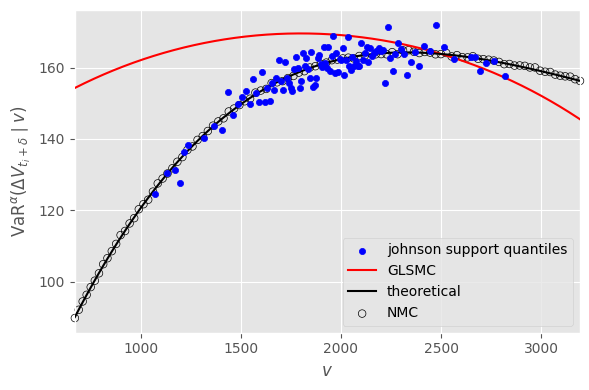

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

var_test_nmc = np.quantile(mtmdiff_nmc_test, alpha, axis=1)

ax.scatter(mtm_supp, quanthat_supp_jlsmc, color=color_jlsmc, s=20, zorder=5, clip_on=False, label='johnson support quantiles')
#ax.scatter(mtm_supp[ind_totest_supp], quanthat_supp_jlsmc[ind_totest_supp], color='green', s=20, zorder=5, clip_on=True)
ax.plot(mtm_func[maskhat_func_glsmc[:, 0]], varhat_func_glsmc, color=color_glsmc, label='GLSMC', zorder=3, clip_on=True)
ax.plot(mtm_test, var_test, color='black', label='theoretical', zorder=3, clip_on=True)
ax.scatter(mtm_test, var_test_nmc, color='black', s=30, facecolors='none', label='NMC', zorder=2, clip_on=False)
ax.set_xlabel('$v$')
ax.set_ylabel('$\\text{VaR}^\\alpha(\\Delta V_{t_i+\\delta} \\mid v)$')
ax.set_xlim(np.min(mtm_test), np.max(mtm_test))
ax.legend(loc='lower right')
plt.tight_layout()
#plt.savefig(f'figures/johnson_fitting/time_{tref:.2f}_Nnmc_{Nnmc_jpf}_z_{z}_pm.png', bbox_inches='tight', dpi=300)
plt.show()

In [184]:
'''
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

dict_settings = {'A': {'Nnmc': 10000, 'z': 0.2}, 
                 'B': {'Nnmc': 10000, 'z': 1}, 
                 'C': {'Nnmc': 1000, 'z': 0.2}, 
                 'D': {'Nnmc': 1000, 'z': 1}}

for i, (key, setting) in enumerate(dict_settings.items()):
    Nnmc_jpf = setting['Nnmc']
    z = setting['z']
    
    jparamshat_supp, jtypehat_supp, mask_hat_supp_jlsmc = percentile_matching_johnson(mtm_supp, S_train, mtm_train, ind_tref, Nnmc_jpf, z)
    jparamshat_supp, jtypehat_supp, mtm_supp = jparamshat_supp[mask_hat_supp_jlsmc], jtypehat_supp[mask_hat_supp_jlsmc], mtm_supp[mask_hat_supp_jlsmc]
    quanthat_supp_jlsmc, mask_hat_supp_johnson  = utils.get_quantile_johnson(jparamshat_supp, jtypehat_supp, np.array([alpha]))
    mtm_supp            = mtm_supp[mask_hat_supp_johnson.reshape(-1)]
    quanthat_supp_jlsmc = quanthat_supp_jlsmc[mask_hat_supp_johnson]

    axs[i].scatter(mtm_supp, quanthat_supp_jlsmc, color=color_jlsmc, s=20, zorder=5, clip_on=True, label='johnson support quantiles')
    axs[i].plot(mtm_func[maskhat_func_glsmc[:, 0]], varhat_func_glsmc, color=color_glsmc, label='GLSMC', zorder=3, clip_on=True)
    axs[i].plot(mtm_test, var_test, color='black', label='theoretical', zorder=3, clip_on=True)
    axs[i].set_xlabel('$v$')
    axs[i].set_ylabel('$\\text{VaR}^\\alpha(\\Delta V_{t_i+\\delta} \\mid v)$')
    axs[i].set_xlim(np.min(mtm_test), np.max(mtm_test))
    axs[i].set_title(f"M'={Nnmc_jpf}, z={z}")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.03))
plt.tight_layout()
#plt.savefig(f'figures/johnson_fitting/time_{tref:.2f}_all_pm.png', bbox_inches='tight', dpi=300)
plt.show()
'''

'\nfig, axs = plt.subplots(2, 2, figsize=(12, 8))\naxs = axs.flatten()\n\ndict_settings = {\'A\': {\'Nnmc\': 10000, \'z\': 0.2}, \n                 \'B\': {\'Nnmc\': 10000, \'z\': 1}, \n                 \'C\': {\'Nnmc\': 1000, \'z\': 0.2}, \n                 \'D\': {\'Nnmc\': 1000, \'z\': 1}}\n\nfor i, (key, setting) in enumerate(dict_settings.items()):\n    Nnmc_jpf = setting[\'Nnmc\']\n    z = setting[\'z\']\n\n    jparamshat_supp, jtypehat_supp, mask_hat_supp_jlsmc = percentile_matching_johnson(mtm_supp, S_train, mtm_train, ind_tref, Nnmc_jpf, z)\n    jparamshat_supp, jtypehat_supp, mtm_supp = jparamshat_supp[mask_hat_supp_jlsmc], jtypehat_supp[mask_hat_supp_jlsmc], mtm_supp[mask_hat_supp_jlsmc]\n    quanthat_supp_jlsmc, mask_hat_supp_johnson  = utils.get_quantile_johnson(jparamshat_supp, jtypehat_supp, np.array([alpha]))\n    mtm_supp            = mtm_supp[mask_hat_supp_johnson.reshape(-1)]\n    quanthat_supp_jlsmc = quanthat_supp_jlsmc[mask_hat_supp_johnson]\n\n    axs[i].scatter(

In [189]:
settings_list = [
    {'id': 0, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2},
    {'id': 1, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 3},
    {'id': 2, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 4},
    {'id': 3, 'method': 'KR', 'bandwidth':'cv_ls'},
    {'id': 4, 'method': 'kNN', 'n_neighbors':1},
    {'id': 5, 'method': 'kNN', 'n_neighbors':3},
    {'id': 6, 'method': 'kNN', 'n_neighbors':5}
]
settingvar_jlsmc = settings_list[0]

varhat_pred_list_jlsmc  = utils.get_var_jlsmc(mtm_supp, quanthat_supp_jlsmc, [mtm_func, mtm_comp, mtm_train], settingvar_jlsmc)
varhat_func_jlsmc       = varhat_pred_list_jlsmc[0]
varhat_comp_jlsmc       = varhat_pred_list_jlsmc[1]
varhat_train_jlsmc      = varhat_pred_list_jlsmc[2]

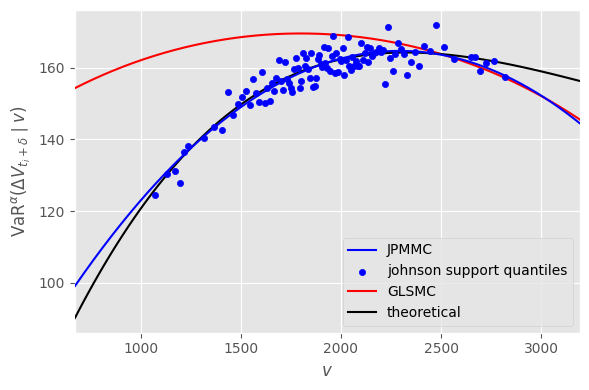

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(mtm_func, varhat_func_jlsmc, color=color_jlsmc, zorder=4, clip_on=True, label='JPMMC')
ax.scatter(mtm_supp, quanthat_supp_jlsmc, color=color_jlsmc, s=20, zorder=5, clip_on=False, label='johnson support quantiles')
ax.plot(mtm_func[maskhat_func_glsmc[:, 0]], varhat_func_glsmc, color=color_glsmc, label='GLSMC', zorder=3, clip_on=True)
ax.plot(mtm_test, var_test, color='black', label='theoretical', zorder=3, clip_on=True)
ax.set_xlabel('$v$')
ax.set_ylabel('$\\text{VaR}^\\alpha(\\Delta V_{t_i+\\delta} \\mid v)$')
ax.set_xlim(np.min(mtm_test), np.max(mtm_test))
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f'figures/johnson_fitting/time_{tref:.2f}_set{settingvar_jlsmc['id']}_varhatpm.png', bbox_inches='tight', dpi=300)
plt.show()

In [72]:
mse_jlsmc   = np.mean((varhat_comp_jlsmc - quant_comp)**2) / np.mean((quant_comp)**2)
print(f'normalized MSE JLSMC        : {mse_jlsmc:.4f}')
mse_glsmc   = np.mean((varhat_comp_glsmc - quant_comp[maskhat_comp_glsmc[:, 0]])**2) / np.mean((maskhat_comp_glsmc[:, 0])**2)
print(f'normalized MSE GLSMC        : {mse_glsmc:.4f}')
ratio_mse   = mse_glsmc / mse_jlsmc
print(f'ratio MSE GLSMC vs JLSMC    : {ratio_mse:.4f}')

normalized MSE JLSMC        : 0.0000
normalized MSE GLSMC        : 0.3648
ratio MSE GLSMC vs JLSMC    : 8815.5557


## <span id="section-5" style="color:#00B8DE"> V - Additional Statistical Verifications </span>

In [73]:
alpha_qq                                    = np.linspace(0.001, 0.999, 1000)
qq_quanthat_ref_jlsmc, mask_hat_ref_johnson = utils.get_quantile_johnson(jparamshat_ref, jtypehat_ref, alpha_qq)
qq_quanthat_ref_glsmc                       = utils.get_quantile_normal(murawhat_ref_glsmc[:, 0], muhat_ref_glsmc[:, 0], alpha_qq)

In [74]:
pvalad_ref      = normal_ad(mtmdiff_nmc_ref[0])[1]
pvalhat_ksn_ref = kstest(mtmdiff_nmc_ref[0], 'norm', args=(0, np.sqrt(muhat_ref_glsmc[0, 0]))).pvalue


print(f'pval AD (normal): {pvalad_ref:.4%}')
print(f'pval KS (normal): {pvalhat_ksn_ref:.4%}')

pval AD (normal): 0.0000%
pval KS (normal): 0.0000%


In [75]:
jparams_ref, jtype_ref, _   = as99.f_johnson_M(muraw_ref[0, 0], np.sqrt(mu_ref[0, 0]), skew_ref[0], kurt_ref[0])
if jtype_ref == 'SL':
    jparams_ref_mle = lognorm.fit(mtmdiff_nmc_ref[0])
elif jtype_ref == 'SU':
    jparams_ref_mle = johnsonsu.fit(mtmdiff_nmc_ref[0])
elif (jtype_ref=='SB') or (jtype_ref=='ST'):
    jparams_ref_mle = johnsonsb.fit(mtmdiff_nmc_ref[0])
elif jtype_ref == 'SN':
    jparams_ref_mle = norm.fit(mtmdiff_nmc_ref[0])

print(f'Johnson params from nested MC moments and MLE   ({jtype_ref}) : {jparams_ref_mle}')
print(f'Johnson params from nested MC moments and MM    ({jtype_ref}) : ({jparams_ref[0]:.2f}, {jparams_ref[1]:.2f}, {jparams_ref[2]:.2f}, {jparams_ref[3]:.2f})')
print(f'Jhonson params from regressed moments and MM    ({rev_jtypes_map[jtypehat_ref[0]]}) : {jparamshat_ref[0, :]}')

Johnson params from nested MC moments and MLE   (SL) : (np.float64(0.023145888453629013), np.float64(-1113.240285281946), np.float64(1113.8921642757678))
Johnson params from nested MC moments and MM    (SL) : (-372.21, 51.70, 1338.89, -1.00)
Jhonson params from regressed moments and MM    (SU) : [  7.03311417  18.6549751  175.70185949 451.97507957]


In [ ]:
def pval_ks_johnson(mtm, jparams, jtype):
    if jtype == jtypes_map['SL']:
        return kstest(mtm, 'lognorm', args=(1/jparams[1], jparams[2], exp(-jparams[0]/jparams[1]))).pvalue
    elif jtype == jtypes_map['SU']:
        return kstest(mtm, 'johnsonsu', args=(jparams[0], jparams[1], jparams[2], jparams[3])).pvalue
    elif (jtype==jtypes_map['SB']) or (jtype==jtypes_map['ST']):
        return kstest(mtm, 'johnsonsb', args=(jparams[0], jparams[1], jparams[2], jparams[3])).pvalue
    elif jtype == jtypes_map['ST']:
        return kstest(mtm, 'norm', args=(jparams[2], jparams[3])).pvalue
    
pvalhat_ksj_ref     = pval_ks_johnson(mtmdiff_nmc_ref[0], jparamshat_ref[0], jtypehat_ref[0])
pval_ksj_ref        = pval_ks_johnson(mtmdiff_nmc_ref[0], jparams_ref, jtypes_map[jtype_ref])
pval_ksj_ref_mle    = pval_ks_johnson(mtmdiff_nmc_ref[0], jparams_ref_mle, jtypes_map[jtype_ref])

print(f'pval KS from nested MC moments and MLE  ({jtype_ref}) : {(pval_ksj_ref_mle):.2%}')
print(f'pval KS from nested MC moments and MM   ({jtype_ref}) : {(pval_ksj_ref):.2%}')
print(f'pval KS from PM   ({rev_jtypes_map[jtypehat_ref[0]]}) : {(pvalhat_ksj_ref):.2%}')

pval KS from nested MC moments and MLE  (SL) : nan%
pval KS from nested MC moments and MM   (SL) : 0.00%
pval KS from PM   (SU) : 4.12%


In [77]:
mtm_supp[ind_totest_supp]

np.float64(1920.5186565928143)

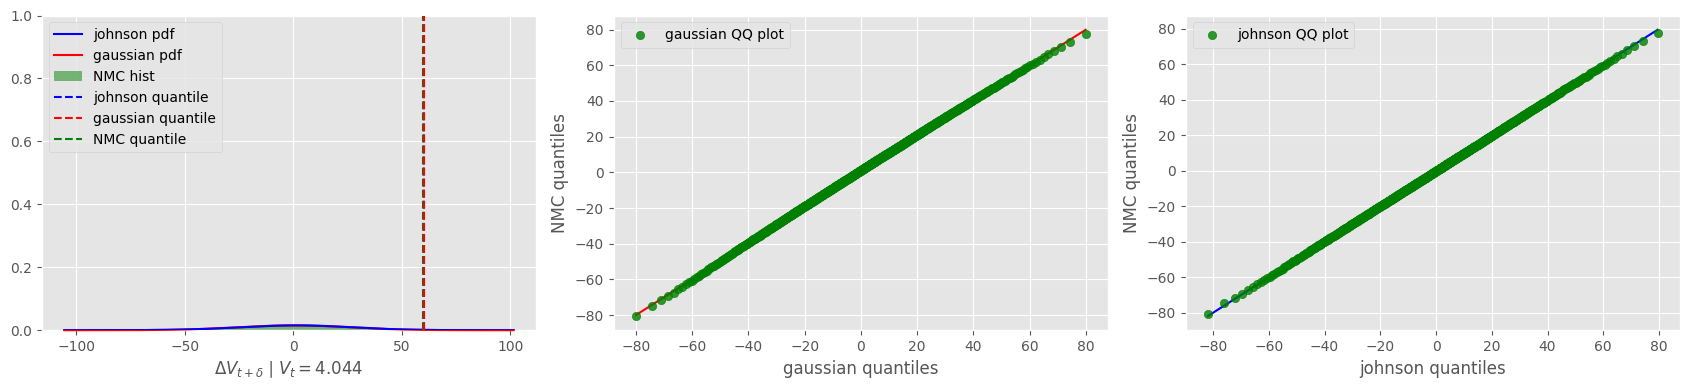

In [78]:
fig, axs = plt.subplots(1, 3, figsize=(17, 4))

axs[0].plot(mtmdiff_pdf_ref, pdfhat_ref_jlsmc[0], color=color_jlsmc, label='johnson pdf', zorder=4, clip_on=True)
axs[0].plot(mtmdiff_pdf_ref, pdfhat_ref_glsmc[0], color=color_glsmc, label='gaussian pdf', zorder=3, clip_on=False)
axs[0].hist(mtmdiff_nmc_ref[0], bins=100, density=True, color='green', alpha=0.5, label='NMC hist', zorder=1, clip_on=False)
axs[0].set_ylim(top=1)

axs[0].axvline(x=quanthat_ref_jlsmc, color=color_jlsmc, linestyle='--', label='johnson quantile', zorder=5, clip_on=False)
axs[0].axvline(x=quanthat_ref_glsmc, color=color_glsmc, linestyle='--', label='gaussian quantile', zorder=5, clip_on=False)
axs[0].axvline(x=quant_ref, color='green', linestyle='--', label='NMC quantile', zorder=4, clip_on=False)
axs[0].set_xlabel('$\\Delta V_{t+\\delta} \\mid V_t = 4.044$ ')
axs[0].legend()

axs[1].plot(qq_quanthat_ref_glsmc[0], qq_quanthat_ref_glsmc[0], color=color_glsmc, zorder=3, clip_on=False)
axs[1].scatter(qq_quanthat_ref_glsmc[0], np.quantile(mtmdiff_nmc_ref[0], alpha_qq, method='inverted_cdf'), color='green', label='gaussian QQ plot', alpha=0.8, zorder=3, clip_on=False)
axs[1].set_xlabel('gaussian quantiles')
axs[1].set_ylabel('NMC quantiles')
axs[1].legend()

axs[2].plot(qq_quanthat_ref_jlsmc[0], qq_quanthat_ref_jlsmc[0], color=color_jlsmc, zorder=3, clip_on=False)
axs[2].scatter(qq_quanthat_ref_jlsmc[0], np.quantile(mtmdiff_nmc_ref[0], alpha_qq, method='inverted_cdf'), color='green', label='johnson QQ plot', alpha=0.8, zorder=3, clip_on=False)
axs[2].set_xlabel('johnson quantiles')
axs[2].set_ylabel('NMC quantiles')
axs[2].legend()

plt.tight_layout()
# plt.savefig(f'figures/johnson_fitting/time_{tref:.2f}_ind{ind_totest_supp}_fitqualitypm.png', bbox_inches='tight', dpi=300)
plt.show()

In [79]:
'''
phitter_cont = phitter.Phitter(mtmdiff_ref[0])
phitter_cont.fit()
df = phitter_cont.df_sorted_distributions_sse
df.head(5)
'''

'\nphitter_cont = phitter.Phitter(mtmdiff_ref[0])\nphitter_cont.fit()\ndf = phitter_cont.df_sorted_distributions_sse\ndf.head(5)\n'